## Overview

## Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.basics import *
from fastai.vision import *

In [3]:
plt.style.use(['dark_background'])

## Paths

In [4]:
DATA_PATH = Config.data_path()
PATH = DATA_PATH/"competitions/airbus-ship-detection"
PATH.ls()

[PosixPath('/home/jupyter/.fastai/data/competitions/airbus-ship-detection/train_ship_segmentations_v2.csv.zip'),
 PosixPath('/home/jupyter/.fastai/data/competitions/airbus-ship-detection/test'),
 PosixPath('/home/jupyter/.fastai/data/competitions/airbus-ship-detection/sample_submission_v2.csv'),
 PosixPath('/home/jupyter/.fastai/data/competitions/airbus-ship-detection/train_ship_segmentations_v2.csv'),
 PosixPath('/home/jupyter/.fastai/data/competitions/airbus-ship-detection/train'),
 PosixPath('/home/jupyter/.fastai/data/competitions/airbus-ship-detection/test_v2.zip'),
 PosixPath('/home/jupyter/.fastai/data/competitions/airbus-ship-detection/train_v2.zip')]

In [5]:
df = pd.read_csv(PATH/'train_ship_segmentations_v2.csv')

In [6]:
df.shape

(231723, 2)

In [7]:
df.sample(5)

,ImageId,EncodedPixels
127942,8d25f9e89.jpg,NaN
161514,b258d9018.jpg,NaN
193346,d5cecdc8d.jpg,NaN
24941,1bb3e8191.jpg,NaN
138996,996c262b6.jpg,NaN


In [8]:
eda_df = df.copy()
eda_df['ships'] = eda_df.EncodedPixels.map(lambda row: 1 if isinstance(row, str) else 0)
eda_df = eda_df.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
eda_df['filesize'] = eda_df.ImageId.map(lambda row: (PATH/f"train/{row}").stat().st_size/1024)
eda_df.set_index('ImageId', inplace=True)
eda_df.sample(10)

,ships,filesize
ImageId,,
dbba0a2ee.jpg,0,123.401367
acd5cfbf3.jpg,0,166.784180
fe7c06d41.jpg,0,131.777344
76e766ed2.jpg,1,204.433594
f52058b11.jpg,0,97.107422
9dbaf5f2b.jpg,0,109.842773
d9538fdc1.jpg,0,173.696289
5a3b08639.jpg,1,158.813477
e592f05f3.jpg,0,251.184570


In [9]:
eda_df.ships.describe()

count    192556.000000
mean          0.424412
std           1.199094
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          15.000000
Name: ships, dtype: float64

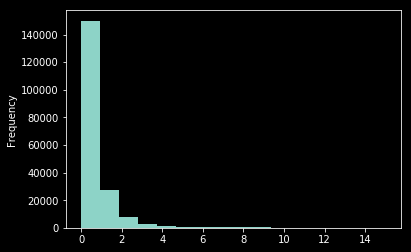

In [10]:
eda_df.ships.plot.hist(bins=16)

In [11]:
eda_df.filesize.describe()

count    192556.000000
mean        147.174686
std          54.292004
min           9.612305
25%         108.333496
50%         130.307617
75%         177.967529
max         511.942383
Name: filesize, dtype: float64

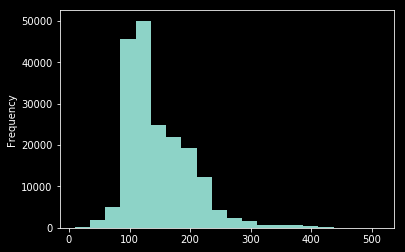

In [12]:
eda_df.filesize.plot.hist(bins=20)

In [13]:
def plot_imgs(fnames):
    nrows = math.ceil(len(fnames) / 4)
    f = plt.figure(figsize=(16, 4 * nrows))
    f.tight_layout()
    
    for i, fpath in enumerate(fnames):
        img = open_image(PATH/'train'/fpath)
        sp = f.add_subplot(nrows, 4, i+1)
        img.show(ax=sp, title=fpath)
        
# Images with minimum and maximum ships
_min, _max = eda_df['ships'].min(), eda_df['ships'].max()
fpath_min = eda_df[eda_df['ships'] == _min].sample().index[0]
fpath_max = eda_df[eda_df['ships'] == _max].sample().index[0]

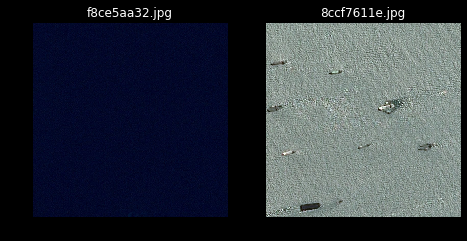

In [13]:
plot_imgs([fpath_min, fpath_max])

In [14]:
# Outliers in size
_min, _max = eda_df['filesize'].min(), eda_df['filesize'].max()
fpath_min = eda_df[eda_df['filesize'] == _min].sample().index[0]
fpath_max = eda_df[eda_df['filesize'] == _max].sample().index[0]

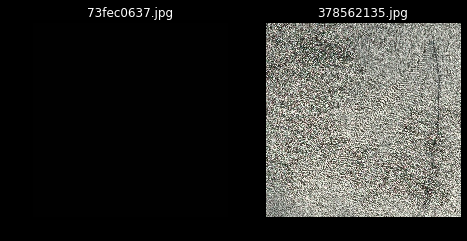

In [14]:
plot_imgs([fpath_min, fpath_max])

In [15]:
# Only images with 100 <= size <= 300
eda_df['clean'] = True
query = (eda_df['filesize'] < 100) | (eda_df['filesize'] > 300)
eda_df.loc[query, 'clean'] = False

In [194]:
eda_df[eda_df['clean']].index

Index(['00003e153.jpg', '000155de5.jpg', '00021ddc3.jpg', '0002756f7.jpg',
       '0002d0f32.jpg', '000303d4d.jpg', '00031f145.jpg', '000532683.jpg',
       '00053c6ba.jpg', '00057a50d.jpg',
       ...
       'fffc6b811.jpg', 'fffcb6464.jpg', 'fffcd0cf7.jpg', 'fffcda6d6.jpg',
       'fffd924fb.jpg', 'fffe4fa23.jpg', 'fffe646cf.jpg', 'ffff2aa57.jpg',
       'ffff6e525.jpg', 'ffffe97f3.jpg'],
      dtype='object', name='ImageId', length=162097)

In [197]:
eda_df.sample(10)

,ships,filesize,clean
ImageId,,,
d09a13121.jpg,5,75.428711,False
a57e55daf.jpg,0,108.203125,True
17de28233.jpg,0,221.639648,True
af6324ff9.jpg,0,106.980469,True
c8034071f.jpg,0,210.110352,True
ac8b30a50.jpg,0,148.142578,True
735263ea1.jpg,0,105.483398,True
5e3971fca.jpg,0,221.833008,True
7e3c48d61.jpg,0,123.119141,True


In [18]:
# Filter out corrupted images, images without ships and outliers to reclaim disk space
exclude_set = ['6384c3e78.jpg','13703f040.jpg', '14715c06d.jpg',  '33e0ff2d5.jpg',
               '4d4e09f2a.jpg', '877691df8.jpg', '8b909bb20.jpg', 'a8d99130e.jpg', 
               'ad55c3143.jpg', 'c8260c541.jpg', 'd6c7f17c7.jpg', 'dc3e7c901.jpg',
               'e44dffe88.jpg', 'ef87bad36.jpg', 'f083256d8.jpg', 'e27eda89e.jpg', 
               '3c1ed3950.jpg']

query = (imgid_df.index.isin(exclude_set))
imgid_df.loc[query, 'clean'] = False
len(imgid_df[imgid_df['clean']].index)

162095

In [19]:
# Clean masks
clean_imgids = imgid_df[imgid_df['clean']].index
masks_df = masks_df[masks_df['ImageId'].isin(clean_imgids)]

### Run-length encode/decode

In [20]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
from skimage.morphology import label

img_shape = (768, 768)

def rle_encode(img):
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def multi_rle_encode(img):
    labels = label(img[:, :, 0])
    return [rle_encode(labels==k) for k in np.unique(labels[labels>0])]

def rle_decode(mask_rle):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(img_shape[0]*img_shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(img_shape).T  # Needed to align to RLE direction

def multi_rle_decode(masks):
    # Decode ship masks and overlay them into one numpy array
    mask_img = np.zeros(img_shape, dtype=np.uint8)
    for mask in masks:
        if isinstance(mask, str):
            mask_img += rle_decode(mask)
    return np.expand_dims(mask_img, -1)

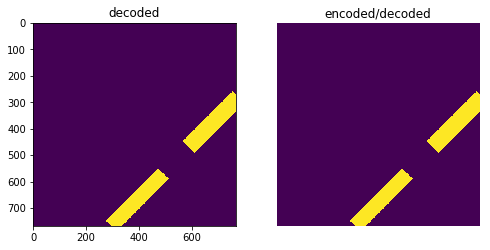

In [91]:
# Check that encode/decode works
def check_encode_decode():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (8, 4))
    
    img_id = masks_df['ImageId'].sample().iloc[0]
    rle_0 = masks_df[masks_df['ImageId'] == img_id]['EncodedPixels']
    img_0 = multi_rle_decode(rle_0)
    ax1.imshow(img_0[:, :, 0])
    ax1.set_title('decoded')
    
    rle_1 = multi_rle_encode(img_0)
    img_1 = multi_rle_decode(rle_1)
    ax2.imshow(img_0[:, :, 0])
    ax2.set_title('encoded/decoded')
    
    plt.axis('off')
    plt.show()
    
check_encode_decode()

### Setting up data loaders

In [21]:
# Custom ImageItemList: Open mask from masks_df, not from disk
def mask_image_to_segment(mask_img):
    mask_tensor = basic_data.FloatTensor(mask_img)
    mask_tensor = mask_tensor.view(img_shape[1], img_shape[0], -1)
    return vision.ImageSegment(mask_tensor.permute(2,0,1))

def open_mask(fn):
    img_id = fn.stem + fn.suffix
    masks = masks_df[masks_df['ImageId'] == img_id]['EncodedPixels']
    mask_img = multi_rle_decode(masks)
    mask_img = mask_image_to_segment(mask_img)
    return mask_img

class SegmentationLabelList(vision.ImageItemList):
    _processor=vision.data.SegmentationProcessor
    def __init__(self, items:basic_data.Iterator, classes:basic_data.Collection=None, **kwargs):
        super().__init__(items, **kwargs)
        self.copy_new.append('classes')
        self.classes, self.loss_func = classes, layers.CrossEntropyFlat(axis=1)

    def open(self, fn): return open_mask(fn)
    def analyze_pred(self, pred, thresh:float=0.5): return pred.argmax(dim=0)[None]
    def reconstruct(self, t:basic_data.Tensor): return vision.ImageSegment(t)

class SegmentationItemList(vision.ImageItemList):
    "`ItemList` suitable for segmentation tasks."
    _label_cls,_square_show_res = SegmentationLabelList, False

In [22]:
def get_data(bs=16, img_size=(256, 256)):
    # Do not augment since we have a large dataset anyway, only resize
    tfms = ([vision.transform.crop_pad()], [vision.transform.crop_pad()])
    
    # Segmentation task only on images with ships
    with_ships_imgids = imgid_df[imgid_df['ships'] > 0].index
    def filter_func(x):
        img_id = x.stem + x.suffix
        return img_id in clean_imgids and img_id in with_ships_imgids
    
    return (SegmentationItemList.from_folder(path/'train_v2')
            .filter_by_func(filter_func)
            .random_split_by_pct(0.2)
            .label_from_func(lambda x: x, classes=[0, 1])
            .transform(tfms, size=img_size, tfm_y=True)
            .databunch(path=path, bs=bs)
            .normalize(vision.imagenet_stats))

data = get_data(bs=28)
data

ImageDataBunch;

Train: LabelList
y: SegmentationLabelList (26628 items)
[ImageSegment (1, 768, 768), ImageSegment (1, 768, 768), ImageSegment (1, 768, 768), ImageSegment (1, 768, 768), ImageSegment (1, 768, 768)]...
Path: data/train_v2
x: SegmentationItemList (26628 items)
[Image (3, 768, 768), Image (3, 768, 768), Image (3, 768, 768), Image (3, 768, 768), Image (3, 768, 768)]...
Path: data/train_v2;

Valid: LabelList
y: SegmentationLabelList (6657 items)
[ImageSegment (1, 768, 768), ImageSegment (1, 768, 768), ImageSegment (1, 768, 768), ImageSegment (1, 768, 768), ImageSegment (1, 768, 768)]...
Path: data/train_v2
x: SegmentationItemList (6657 items)
[Image (3, 768, 768), Image (3, 768, 768), Image (3, 768, 768), Image (3, 768, 768), Image (3, 768, 768)]...
Path: data/train_v2;

Test: None

(256, 256, 3)


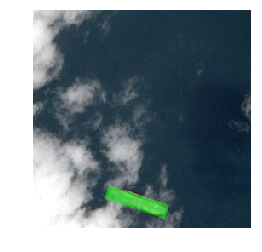

In [74]:
# Make sure transformations work
import cv2

def mask_overlay(image, mask, color=(0, 1, 0)):
    mask = np.dstack((mask, mask, mask)) * np.array(color)
    mask = mask.astype(image.dtype)
    weighted_sum = cv2.addWeighted(mask, 0.5, image, 0.5, 0.)
    img = image.copy()
    ind = mask[:, :, np.argmax(color)] > 0
    img[ind] = weighted_sum[ind]    
    return img

def imshow(idx=None):
    if idx is None:
        idx = random.choice(range(len(data.train_ds)))
        
    img = data.train_ds[idx][0]
    img = img.data.permute(1, 2, 0).numpy()
    mask_img = data.train_ds[idx][1]
    mask_img = mask_img.data.permute(1, 2, 0).numpy()
    overlayed = mask_overlay(img, mask_img)
    print(overlayed.shape)
    
    plt.imshow(overlayed)
    plt.axis('off')
    plt.show()
    
imshow()

## Image segmentation

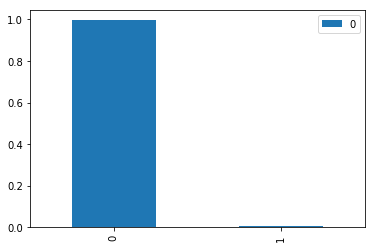

In [37]:
# Measure class imbalance by counting pixels
def plot_pixel_counts(num_samples=100):
    num_imgs = len(data.train_ds)
    counts = np.zeros((num_imgs, data.c))
    random_idxs = random.sample(range(num_imgs), num_samples)
    
    for idx in random_idxs:
        mask_tensor = data.train_ds[idx][1].data
        for c in range(data.c):
            counts[idx, c] = (mask_tensor == c).sum()
    
    rel_counts = counts.sum(axis=0)/counts.sum()
    df = pd.DataFrame(rel_counts, index=data.classes)
    df.plot.bar()
    plt.show()
    
plot_pixel_counts()

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

# https://becominghuman.ai/investigating-focal-and-dice-loss-for-the-kaggle-2018-data-science-bowl-65fb9af4f36c
def cuda(x): 
    return x.cuda() if torch.cuda.is_available() else x

def make_one_hot(labels, c=2):
    one_hot = cuda(torch.FloatTensor(labels.size(0), c, labels.size(2), labels.size(3)).zero_())
    target = one_hot.scatter_(1, labels.data, 1)
    target = cuda(Variable(target))
    return target

def dice_loss(input, target):
    # Input is of shape N,C,H,W
    smooth = 1
    batch_size = input.size(0)
    input = F.softmax(input, dim=1)
    # Since we have only 2 classes transform it to N,H,W and treat as sigmoid
    input = input.view(batch_size, 2, -1)[:, 1, :]
    target = make_one_hot(target).view(batch_size, 2, -1)[:, 1, :]

    inter = torch.sum(input * target) + smooth
    union = torch.sum(input) + torch.sum(target) + smooth

    return -torch.log(2.0 * inter / union)

class FocalLoss(nn.Module):
    # This loss function demonstrates amazing results on datasets with unbalance level 1:10-1000
    def __init__(self, gamma):
        super(FocalLoss, self).__init__()
        self.gamma = gamma

    def forward(self, input, target):
        # One-hot encode target
        target = target.squeeze(1)
    
        input = input.view(input.size(0),input.size(1),-1) # N,C,H,W => N,C,H*W
        input = input.transpose(1,2)                       # N,C,H*W => N,H*W,C
        input = input.contiguous().view(-1,input.size(2))  # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input, dim=1)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        loss = -1 * (1-pt)**self.gamma * logpt
        return loss.mean()
    
# https://www.kaggle.com/iafoss/unet34-dice-0-87
class MixedLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma)
        
    def forward(self, input, target):
        return self.alpha * self.focal(input, target) + dice_loss(input, target)

loss_func = MixedLoss(10., 2.)

In [24]:
def dice(input, target):
    input = input.argmax(dim=1).float()
    target = target.squeeze(1).float()
    
    smooth = 1.
    numerator = 2. * (input * target).sum()
    denumerator = (input + target).sum()
    return (numerator + smooth) / (denumerator + smooth)

def IoU(input, target):
    input = input.argmax(dim=1).float()
    target = target.squeeze(1).float()
    
    smooth = 1.
    intersection = (input * target).sum()
    union = (input + target).sum() - intersection
    return (intersection + smooth) / (union + smooth)

metrics = [dice, IoU]

In [28]:
# Put learn in FP16 precision mode
learn = vision.unet_learner(data, vision.models.resnet34, metrics=metrics, loss_func=loss_func, wd=1e-2).to_fp16()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


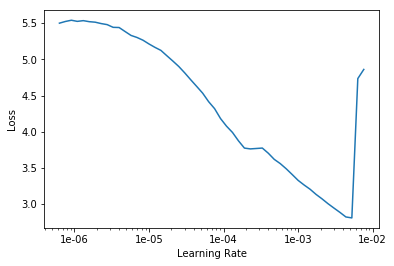

In [29]:
learn.lr_find()
learn.recorder.plot()

In [30]:
learn.fit_one_cycle(5, slice(1e-03), pct_start=0.9)

epoch,train_loss,valid_loss,dice,IoU
1,0.330177,0.304868,0.804926,0.676646
2,0.271886,0.260295,0.829330,0.710994
3,0.242063,0.238031,0.844326,0.732464
4,0.224682,0.217465,0.856356,0.750792
5,0.150684,0.164680,0.888369,0.800362


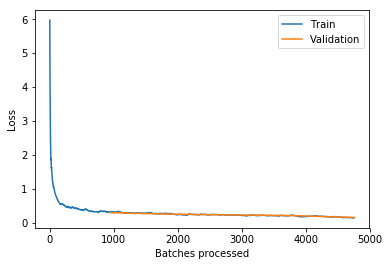

In [31]:
learn.recorder.plot_losses()

In [32]:
learn.save('Unet34_256_1')

In [29]:
learn.load('Unet34_256_1');

In [30]:
learn.unfreeze()

In [31]:
# Decrease batch size after unfreezing
learn.data = get_data(bs=24)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


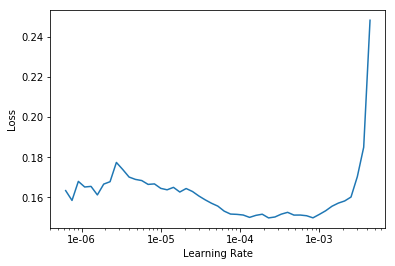

In [32]:
learn.lr_find()
learn.recorder.plot()

In [33]:
learn.fit_one_cycle(5, slice(1e-06, 1e-04))

epoch,train_loss,valid_loss,dice,IoU
1,0.137380,0.139075,0.904966,0.827307
2,0.132071,0.131390,0.910007,0.835684
3,0.124420,0.125592,0.913685,0.841809
4,0.113460,0.121133,0.916709,0.846913
5,0.111492,0.120643,0.917260,0.847836


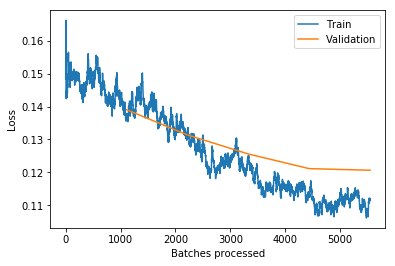

In [34]:
learn.recorder.plot_losses()

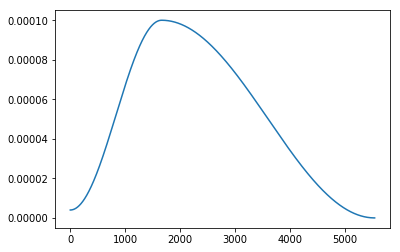

In [35]:
learn.recorder.plot_lr()

In [36]:
learn.save('Unet34_256_2')

In [41]:
# We only train with 256-sized images since their quality doesn't get any better with their size.

### Model evaluation

In [25]:
data = get_data(bs=1)

In [26]:
learn = vision.unet_learner(data, vision.models.resnet34, metrics=metrics, loss_func=loss_func)

In [27]:
learn.load('Unet34_256_2');

In [30]:
outputs, targets = learn.get_preds(vision.DatasetType.Valid)

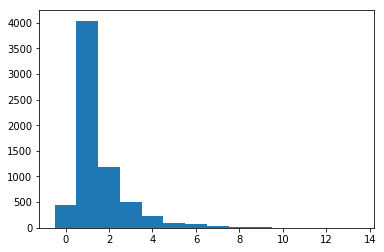

In [31]:
def count_ships(outputs):
    ship_counts = []
    for idx, output in enumerate(outputs):
        probs = F.softmax(output, dim=0)
        mask_tensor = probs.argmax(dim=0)
        mask_tensor = mask_tensor.unsqueeze(2)
        masks = multi_rle_encode(mask_tensor)
        ship_counts.append(len(masks))
    return np.array(ship_counts)

ship_counts = count_ships(outputs)
plot_hist(ship_counts, 1)

torch.Size([3, 256, 256]) torch.Size([1, 256, 256]) torch.Size([1, 256, 256])


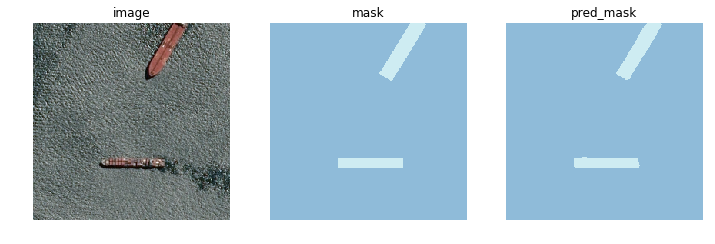

In [82]:
# Make sure decode works
def imshow_valid():
    idx = random.choice(range(len(data.valid_ds)))
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
    img = learn.data.valid_ds[idx][0]
    mask = learn.data.valid_ds[idx][1]
    img.show(ax=ax1)
    ax1.set_title('image')
    mask.show(ax=ax2)
    ax2.set_title('mask')
    print(img.shape, mask.shape, learn.predict(img)[0].shape)
    learn.predict(learn.data.valid_ds[idx][0])[0].show(ax=ax3)
    ax3.set_title('pred_mask')
    
    plt.axis('off')
    plt.show()
    
imshow_valid()

In [28]:
# Export inference learner
learn.export('Unet34_256.pkl')

/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type MixedLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type FocalLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


## Binary classification

In [20]:
# How balanced is the dataset?
wo_ships_query = imgid_df['clean'] & (imgid_df['ships'] == 0)
w_ships_query = imgid_df['clean'] & (imgid_df['ships'] > 0)
imgid_wo_ships = set(imgid_df[wo_ships_query].index)
imgid_w_ships = set(imgid_df[w_ships_query].index)

len(imgid_wo_ships), len(imgid_w_ships)

(128810, 33285)

In [21]:
# Downsample image without ships
cl_imgids = set(random.sample(imgid_wo_ships, len(imgid_w_ships))) | imgid_w_ships

len(cl_imgids)

66570

In [22]:
def get_cl_data(bs=64, img_size=(256, 256)):
    tfms = vision.get_transforms(flip_vert=True, max_zoom=1., max_warp=None, max_lighting=None)
    return (vision.ImageItemList.from_folder(path/'train_v2')
            .filter_by_func(lambda x: (x.stem + x.suffix) in cl_imgids)
            .random_split_by_pct(0.2)
            .label_from_func(lambda x: (x.stem + x.suffix) in imgid_w_ships)
            .transform(tfms, size=img_size)
            .databunch(path=path, bs=bs)
            .normalize(vision.imagenet_stats))

cl_data = get_cl_data()
cl_data

ImageDataBunch;

Train: LabelList
y: CategoryList (53256 items)
[Category True, Category False, Category True, Category True, Category True]...
Path: data/train_v2
x: ImageItemList (53256 items)
[Image (3, 768, 768), Image (3, 768, 768), Image (3, 768, 768), Image (3, 768, 768), Image (3, 768, 768)]...
Path: data/train_v2;

Valid: LabelList
y: CategoryList (13314 items)
[Category False, Category False, Category False, Category True, Category False]...
Path: data/train_v2
x: ImageItemList (13314 items)
[Image (3, 768, 768), Image (3, 768, 768), Image (3, 768, 768), Image (3, 768, 768), Image (3, 768, 768)]...
Path: data/train_v2;

Test: None

In [23]:
cl_learn = vision.create_cnn(cl_data, vision.models.resnet34, metrics=metrics.accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


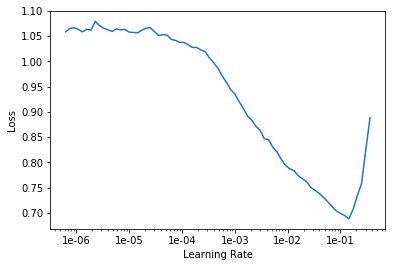

In [24]:
cl_learn.lr_find()
cl_learn.recorder.plot()

In [25]:
cl_learn.fit_one_cycle(5, slice(1e-2))

epoch,train_loss,valid_loss,accuracy
1,0.237676,0.139811,0.946598
2,0.192989,0.126411,0.952606
3,0.157286,0.111658,0.959066
4,0.130949,0.087380,0.968229
5,0.130832,0.089485,0.967027


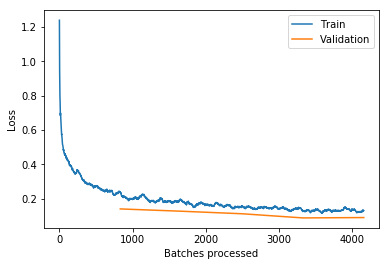

In [31]:
cl_learn.recorder.plot_losses()

In [34]:
cl_learn.save('Resnet34_256_1')

In [24]:
cl_learn.load('Resnet34_256_1');

In [25]:
cl_learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


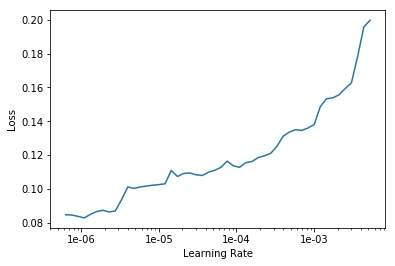

In [26]:
cl_learn.lr_find()
cl_learn.recorder.plot()

In [27]:
cl_learn.fit_one_cycle(10, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy
1,0.115520,0.087944,0.969731
2,0.113862,0.081118,0.970407
3,0.094870,0.075243,0.973336
4,0.097015,0.073903,0.974538
5,0.083740,0.065513,0.977017
6,0.076560,0.063514,0.978068
7,0.072485,0.063701,0.977993
8,0.069260,0.060580,0.979120
9,0.076709,0.058557,0.978669
10,0.065059,0.057908,0.979345


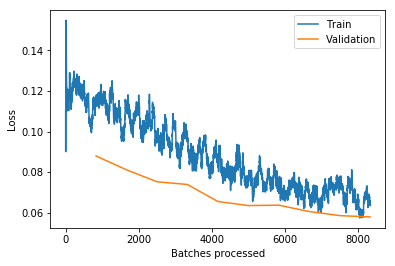

In [28]:
cl_learn.recorder.plot_losses()

In [29]:
cl_learn.save('Resnet34_256_2')

### Model evaluation

In [31]:
cl_data = get_cl_data()

In [32]:
cl_learn = vision.create_cnn(cl_data, vision.models.resnet34, metrics=metrics.accuracy)

In [33]:
cl_learn.load('Resnet34_256_2');

In [52]:
interp = vision.ClassificationInterpretation.from_learner(cl_learn)

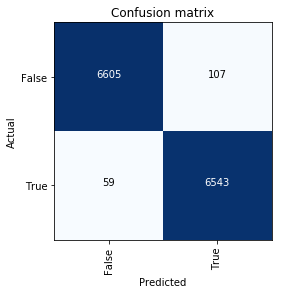

In [60]:
interp.plot_confusion_matrix()

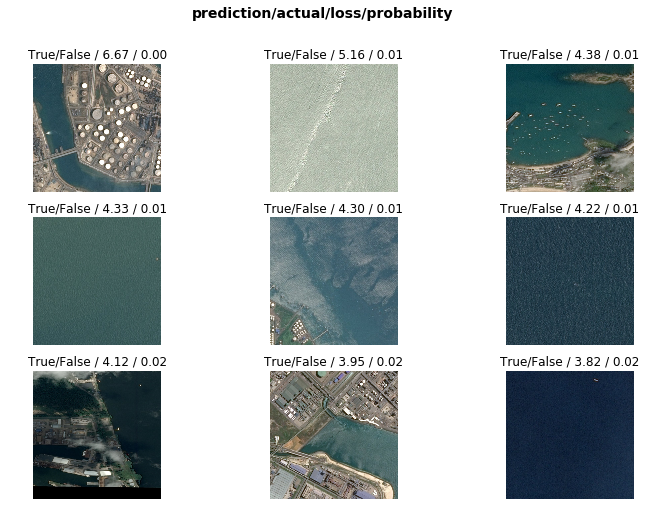

In [59]:
interp.plot_top_losses(9, figsize=(12, 8))

In [62]:
cl_learn.export('Resnet34_256.pkl')

In [ ]:
# Also look at 
# https://towardsdatascience.com/image-segmentation-kaggle-experience-9a41cb8924f0
# https://github.com/kheyer/ML-DL-Projects/tree/master/Airbus%20Ship%20Detection